### Fashion MNIST classifier model

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
batch_size   = 128
valid_size   = 0.2
epochs       = 5
transform    = transforms.ToTensor()  # Convert image to Tensor

In [3]:
# Download the Train and Test set

trainset = datasets.FashionMNIST('.', train=True, download=True, transform=transform)
testset = datasets.FashionMNIST('.', train=False, download=True, transform=transform)

print("Length of the train set", len(trainset))
print("Length of the test set", len(testset))

Length of the train set 60000
Length of the test set 10000


Label: 0


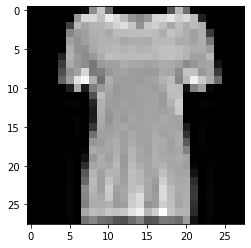

In [4]:
# Sample image from the train set and the label

img_num = 10
print("Label:", trainset[img_num][1])
plt.imshow(trainset[img_num][0][0,:,:],'gray');

In [5]:
# Split the training set indices into training and validation set indices using 80:20 ratio

val_size   = int(len(trainset) * valid_size)
train_size = int(len(trainset) * (1-valid_size))
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

In [6]:
# Create dataloaders for training, validation and testing datasets

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
testloader  = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [7]:
# Model Architecture

class FMNIST(nn.Module):
    def __init__(self):
        super(FMNIST,self).__init__()
        self.fc1 = nn.Linear(784, 1500, bias=False)
        self.fc2 = nn.Linear(1500, 750, bias=False)
        self.fc3 = nn.Linear(750, 300, bias=False)
        self.fc4 = nn.Linear(300, 10, bias=False)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)#F.log_softmax(, dim=1)
        return x

In [8]:
# Create model

model = FMNIST()
model

FMNIST(
  (fc1): Linear(in_features=784, out_features=1500, bias=False)
  (fc2): Linear(in_features=1500, out_features=750, bias=False)
  (fc3): Linear(in_features=750, out_features=300, bias=False)
  (fc4): Linear(in_features=300, out_features=10, bias=False)
)

In [9]:
# Defining the Loss function and the Optimization function 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [10]:
# Training and Validation

def train_and_val(model, trainloader, criterion, optimizer, epochs):
    min_val_loss = np.Inf
    
    for epoch in range(epochs):
        train_loss = 0
        valid_loss = 0

        model.train()                                           # TRAINING
        for image, label in trainloader:
            image, label = image, label
            optimizer.zero_grad()                               # Set Gradients to zero
            output = model(image)
            loss   = criterion(output, label)                   # Calculate loss according to CrossEntropy
            loss.backward()                                     # Backward propagation of loss
            optimizer.step()                                    # Run Adam optimiser
            train_loss += loss.item()                           # Set train loss as the accumulated sum of loss times the batch size

        
#         for param in model.parameters():
#             print(param.data)
        
        model.eval()                                            # VALIDATION
        for image, label in validloader:
            image, label = image, label
            output = model(image)
            loss   = criterion(output, label)
            valid_loss += loss.item()

        train_loss = (train_loss*batch_size)/train_size
        val_loss   = (valid_loss*batch_size)/val_size

        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
          epoch+1, 
          train_loss,
          val_loss
          ))

        if val_loss <= min_val_loss:                            # Save the model only if val loss has decreased
            print('Validation loss has decreased ({:.5f} --> {:.5f}).  Model saved!'.format(
            min_val_loss,
            val_loss))
            torch.save(model.state_dict(), 'model_q.pt')
            min_val_loss = val_loss
            
        print()

In [11]:
# Check accuracy - testing

def test_accuracy(model, testloader, criterion):
    test_loss     = 0.0
    class_correct = list(0. for i in range(10))                            # 10 classes
    class_total   = list(0. for i in range(10))

    model.eval()

    for image, target in testloader:
        image, target = image, target
        output = model(image)
        loss   = criterion(output, target)
        test_loss += loss.item()*image.size(0)
        _, pred = torch.max(F.softmax(output, dim=1), 1)                   # Get argmax
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))           # Array of 1's and 0's
        
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()                      # Increment if pred==target
            class_total[label]   += 1
            
    overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)  # Percentage
    return overall_accuracy

In [12]:
# Define a function that will run the training function and the test accuracy

def main(model,epochs=epochs):
    train_and_val(model,trainloader, criterion, optimizer, epochs)
    
    model.load_state_dict(torch.load('model_q.pt'))
    
    accuracy = test_accuracy(model, testloader, criterion)
    
    return model, accuracy

In [13]:
# Run training and validation here or load the saved model like in the next code block

model, model_accuracy = main(model)
print(model_accuracy)

Epoch: 1 	Training Loss: 0.67668 	Validation Loss: 0.48468
Validation loss has decreased (inf --> 0.48468).  Model saved!

Epoch: 2 	Training Loss: 0.45694 	Validation Loss: 0.43210
Validation loss has decreased (0.48468 --> 0.43210).  Model saved!

Epoch: 3 	Training Loss: 0.41891 	Validation Loss: 0.41219
Validation loss has decreased (0.43210 --> 0.41219).  Model saved!

Epoch: 4 	Training Loss: 0.40419 	Validation Loss: 0.42011

Epoch: 5 	Training Loss: 0.38635 	Validation Loss: 0.40298
Validation loss has decreased (0.41219 --> 0.40298).  Model saved!

84.77


In [14]:
# In case you want to load the model again

# model.load_state_dict(torch.load('model_q.pt'))

In [15]:
# Function to print the size of the model

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(model)

Size (MB): 10.116807


### Dynamic Quantization  
Now that the original FMNIST model has been defined and trained, we can specify which layers we want to quantize. Here, we will specify nn.Linear layers for quatization but, in our model, we only have nn.Linear layers so all the layers get quantized. If the model had CNN layers then those layers would not get quantized.<br>
We also specify that we want weights to be converted to int8 values.

In [16]:
import torch.quantization

dynamic_quantized_model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)

In [17]:
print_size_of_model(dynamic_quantized_model)
print_size_of_model(model)

Size (MB): 2.531199
Size (MB): 10.116807


In [18]:
# Compare the performance of the dynamic quantized model against the original model

dynamic_quantized_accuracy = test_accuracy(dynamic_quantized_model, testloader, criterion)
print("Accuracy of the dynamic quantized model: {}%".format(dynamic_quantized_accuracy))

original_accuracy          = test_accuracy(model, testloader, criterion)
print("Accuracy of the original model         : {}%".format(original_accuracy))

Accuracy of the dynamic quantized model: 84.75%
Accuracy of the original model         : 84.77%


### Post-training Static Quantization
Statis quantization works by installing observers (for example: *MinMaxOberserver*, *HistogramObserver*, and others) which observe the model from input to the output and collect statistics required to later quantize the parameters. Once the model is prepared this way, we can convert the model (i.e. float32 weights become int8) using an appropriate quantization technique to get the quantized model. And, as expected the size of the model reduces. But, it is not possible to perform inference at this stage as the inputs are still the same and have not been adapted to the quantized model. So the model class needs to be defined again (there is no work around for this problem) with Quantstubs and Dequantstubs. <br>

For more details, please go through "Understanding_quantization.pdf" available in this repository. I found this PDF [here](https://github.com/pytorch/pytorch/issues/18318).

In [19]:
# Redefine the model architecture

from torch.quantization import QConfig, MinMaxObserver, HistogramObserver, default_observer, default_per_channel_weight_observer

class LinearReLU(nn.Sequential):
    def __init__(self,in_channel, out_channel):
        super(LinearReLU,self).__init__(nn.Linear(in_channel, out_channel, bias=False), nn.ReLU())

class FMNIST_quant(nn.Module):
    def __init__(self):
        super(FMNIST_quant,self).__init__()
        my_qconfig    = QConfig(activation=MinMaxObserver.with_args(dtype=torch.quint8),
                                weight=default_per_channel_weight_observer.with_args(dtype=torch.qint8))
        
        self.quant    = torch.quantization.QuantStub(my_qconfig)
        self.sq1      = LinearReLU(784,1500)
        
        self.sq2      = LinearReLU(1500,750)
        
        self.sq3      = LinearReLU(750,300)
        
        self.fc_out   = nn.Linear(300, 10, bias=False)
        
        self.dequant  = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = self.quant(x)
        
        x = F.relu(self.sq1(x))
        x = F.relu(self.sq2(x))
        x = F.relu(self.sq3(x))
        
        x = self.fc_out(x)

        x = self.dequant(x)
        
        return x                        # No need for F.log_softmax() as Cross Entropy loss does that implicitly
    
    def fuse_model(self):
        for m in self.modules():
            if type(m) == LinearReLU:
                torch.quantization.fuse_modules(m, ['0', '1'], inplace=True)

In [20]:
# Function to just implement the forward pass for observer calibration

def calibrate(model, criterion, data_loader, n_eval=150):
    model.eval()
    count = 0
    with torch.no_grad():
        for image, target in data_loader:
            output = model(image)
            loss = criterion(output, target)
            count += 1
            if count >= n_eval:
                return

In [21]:
# Train the model with the observers in place

model_quant = FMNIST_quant()

# Defining the Loss function and the Optimization function 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_quant.parameters(), lr=0.01)

model_quant, model_quant_accuracy = main(model_quant)
print(model_quant_accuracy)

Epoch: 1 	Training Loss: 0.68940 	Validation Loss: 0.50005
Validation loss has decreased (inf --> 0.50005).  Model saved!

Epoch: 2 	Training Loss: 0.45383 	Validation Loss: 0.42053
Validation loss has decreased (0.50005 --> 0.42053).  Model saved!

Epoch: 3 	Training Loss: 0.41588 	Validation Loss: 0.44423

Epoch: 4 	Training Loss: 0.40616 	Validation Loss: 0.43227

Epoch: 5 	Training Loss: 0.39755 	Validation Loss: 0.38668
Validation loss has decreased (0.42053 --> 0.38668).  Model saved!

85.41


In [22]:
# View the model

# model_quant

In [23]:
# model_with_stubs.load_state_dict(torch.load('model_q.pt'))
model_quant.eval()

model_quant.fuse_model()

# Set the qconfig - fbgemm for x86 and qnnpack for ARM qnnpack
model_quant.qconfig = QConfig(activation=MinMaxObserver.with_args(dtype=torch.quint8),
                        weight=default_per_channel_weight_observer.with_args(dtype=torch.qint8))
print(model_quant.qconfig)
torch.backends.quantized.engine = 'fbgemm'

# Insert observers, calibrate the model and collect statistics
torch.quantization.prepare(model_quant, inplace=True)

calibrate(model_quant,criterion,testloader)

# Convert to the quantized version
torch.quantization.convert(model_quant, inplace=True)

QConfig(activation=functools.partial(<class 'torch.quantization.observer.MinMaxObserver'>, dtype=torch.quint8), weight=functools.partial(functools.partial(<class 'torch.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric), dtype=torch.qint8))


FMNIST_quant(
  (quant): Quantize(scale=tensor([0.0039]), zero_point=tensor([0]), dtype=torch.quint8)
  (sq1): LinearReLU(
    (0): QuantizedLinearReLU(in_features=784, out_features=1500, scale=0.12596023082733154, zero_point=0, qscheme=torch.per_channel_affine)
    (1): Identity()
  )
  (sq2): LinearReLU(
    (0): QuantizedLinearReLU(in_features=1500, out_features=750, scale=0.15319477021694183, zero_point=0, qscheme=torch.per_channel_affine)
    (1): Identity()
  )
  (sq3): LinearReLU(
    (0): QuantizedLinearReLU(in_features=750, out_features=300, scale=0.5363470315933228, zero_point=0, qscheme=torch.per_channel_affine)
    (1): Identity()
  )
  (fc_out): QuantizedLinear(in_features=300, out_features=10, scale=1.0589793920516968, zero_point=198, qscheme=torch.per_channel_affine)
  (dequant): DeQuantize()
)

In [24]:
# Compare the model size

print_size_of_model(model_quant)  # quantized model
print_size_of_model(model)        # original model

Size (MB): 2.573233
Size (MB): 10.116807


In [25]:
# Compare the test accuracies

static_quantized_accuracy = test_accuracy(model_quant, testloader, criterion)

print("Accuracy of the static quantized model : {}%".format(static_quantized_accuracy))
print("Accuracy of the original model         : {}%".format(model_quant_accuracy))

Accuracy of the static quantized model : 84.44%
Accuracy of the original model         : 85.41%


In [26]:
# View the quantized weights

model_quant.sq1[0].weight().int_repr()

tensor([[  34,   46, -100,  ...,  -64,  -33,  -27],
        [  21,   -3,  -12,  ...,  -76,  -61,   54],
        [ -19,   13,  -80,  ...,  -68,  -68,   -3],
        ...,
        [ -23,  -32,    8,  ...,  -44,   -4,  -31],
        [ -35,   54,  -75,  ...,  -79,  -72,   24],
        [  11,    9,  -24,  ...,  -58,  -62,  -32]], dtype=torch.int8)

In [27]:
# View the stat_dict of the model

for key,val in model_quant.state_dict().items():
    print(key)
    print(val)
    print()

quant.scale
tensor([0.0039])

quant.zero_point
tensor([0])

sq1.0.scale
tensor(0.1260)

sq1.0.zero_point
tensor(0)

sq1.0._packed_params.weight
tensor([[ 0.0304,  0.0412, -0.0895,  ..., -0.0573, -0.0295, -0.0242],
        [ 0.0199, -0.0028, -0.0114,  ..., -0.0720, -0.0578,  0.0511],
        [-0.0178,  0.0122, -0.0750,  ..., -0.0637, -0.0637, -0.0028],
        ...,
        [-0.0260, -0.0362,  0.0090,  ..., -0.0497, -0.0045, -0.0351],
        [-0.0327,  0.0504, -0.0701,  ..., -0.0738, -0.0673,  0.0224],
        [ 0.0101,  0.0083, -0.0221,  ..., -0.0535, -0.0571, -0.0295]],
       size=(1500, 784), dtype=torch.qint8,
       quantization_scheme=torch.per_channel_affine,
       scale=tensor([0.0009, 0.0009, 0.0009,  ..., 0.0011, 0.0009, 0.0009],
       dtype=torch.float64),
       zero_point=tensor([0, 0, 0,  ..., 0, 0, 0]), axis=0)

sq1.0._packed_params.bias
None

sq1.0._packed_params.dtype
torch.qint8

sq2.0.scale
tensor(0.1532)

sq2.0.zero_point
tensor(0)

sq2.0._packed_params.weight
ten